# UMA Raw data EDA

## Import Libraries

In [1]:
# analysis
import numpy as np
import pandas as pd
import json

# other
import warnings
import os
import requests

# visualisation libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")


In [2]:

# credentials_file_loc = "../../../../Admin/authentication_files/uma_api_cred_2021-01-21.json"
# with open(credentials_file_loc , "r") as read_file:
#     data = json.load(read_file)
# data

## Define Helper Functions

In [3]:
def get_api_token(credentials_file_loc):
    """
    This function makes a POST request to Gometro's UMA REST API and returns a valid api token
    
    ------------------------------------
    Parameters:
        credentials_file_loc (str): 
        date (str): column name of field containing the payload of the data
    
    Returns: (str): 
    ------------------------------------
    Example:
    
    
    
    """
    
    # get dictionary of authorisation credentials
    with open(credentials_file_loc , "r") as read_file:
        task = json.load(read_file)
    
    # make api request
    endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
    response = requests.post(endpoint, data=task)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('POST /tasks/ {}'.format(response.status_code))
    
    return response.json()["access_token"]
    
    

In [4]:
def get_raw_user_data(pid, date, token):
    
    """
    This function makes a GET request to Gometro's UMA REST API and returns data from
    the API.
    
    ------------------------------------
    Parameters:
        participant_id (str): column name of field containing the payload of the data
        date (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    
    """
    
    # define API headers
    headers = {'Authorization': f'Bearer {token}'}
    
    # make api request    
    endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/events/{date}'
    response = requests.get(endpoint, headers=headers)
    
    # catch error
    if (response.status_code < 200) and (response.status_code >= 300):
        raise ValueError('GET /tasks/ {}'.format(response.status_code))
    
    # import data
    assert len(response.json()) > 0, "response returned no data"
    df = pd.DataFrame(response.json())
    
    # select location data
    return df[df['type'] == 'LocationChanged']
    

In [5]:
def unpack_payload(df, payload_col = 'payload'):
    
    """
    This function takes a dataframe where the payload is in one column
    and creates a new column for each element in the payload
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
        payload_col (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # import literal_eval function
    from ast import literal_eval

    # make list of column headers from keys
    payload_cols = literal_eval(df['payload'].iloc[0]).keys()
    
    # add columns for each column header to dataframe
    for col in payload_cols:
        df[col] = df['payload'].apply(lambda x: literal_eval(x)[col])
        
    # remove type and payload column
    df.drop(['type', 'payload'], axis=1, inplace=True)
    
    return df



In [20]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    this funtion takes the coordinates between two points and returns
    the distance between the points of the given coordinates in meters.
    
    ------------------------------------
    Parameters:
        lat1 (float): latitude of first point
        lat1 (float): longitude of first point
        lat1 (float): latitude of second point
        lat1 (float): longitude of second point
    
    Returns: (float): distanctance between points (m)
    
    ------------------------------------
    source: https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4
    
    ------------------------------------
    Example:
    
    

    """
    # define constants
    r = 6371
    
    # implement haversine formula
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    
    # convert result to from km to m
    res = res * 1000
    
    return np.round(res, 2)

In [27]:
def prep_data_raw(df):
    
    """
    This function takes data unpacked from GoMetro's UMA REST API using the
    unpack_payload function and returns a dataframe with the following columns
    added to the data
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # convert timetamps to date time
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # shift coordinates
    df['lat_shift'] = df['latitude'].shift(-1)
    df['lon_shift'] = df['longitude'].shift(-1)

    
    # add features
    df['time_change'] = df['timestamp'].diff().dt.seconds
    df['speed_change'] = df['speed'].diff()
    df['acceleration'] = df['speed_change']/df['time_change']
    df['cumm_acceleration'] = df['acceleration'].cumsum()
    df['distance'] = df.apply(lambda x:
                              haversine_distance(x['latitude'],
                                                 x['longitude'],
                                                 x['lat_shift'],
                                                 x['lon_shift']), axis=1)
    
    df['cumm_distance'] = df['distance'].cumsum()
    df.drop(['lat_shift', 'lon_shift'], axis=1, inplace=True)
    
    # make timestamp index
    df = df.set_index('timestamp')
    
    return df

In [8]:
def add_label_units(label):
    """
    This function generates a label with units
    ------------------------------------
    Parameters:
        label (str): column name of field we want units for
    
    Returns:
        (str): column name of field with the units such that '<label> (<unit>)'
    ------------------------------------
    Example:
    
    """
    
    # define dictionary of units for known column names
    units_dict = {'speed': 'm/s',
                  'acceleration': 'm/$s^{2}$',
                  'cumm_acceleration': 'm/$s^{2}$',
                  'bearing': '$&deg;$',
                  'latitude': '$&deg;$',
                  'longitude': '$&deg;$',
                  'accuracy': 'm',
                  'distance': 'm'
                  }
    
    # return units for known column names
    if label in units_dict.keys():
        return f'{label} [{units_dict[label]}]'
    
    # return label for unknown colum names
    return label

In [9]:
def raw_trip_analysis_plot(df, col, participant_id, date,
                           figures_dir=os.path.join('..','..', 'resources', 'reports','figures','raw_data_viz')):
    
    # 1. set size of figure
    fig, ax = plt.subplots(figsize=(400,10))
    
    
    # 2. plot figure
    ax.plot(df.loc[date][col], linestyle='-', color='b')

                        
    # 3. format figure
    # 3.1 set title of figure
    ax.set_title(f"{col} profile over time on {date}")
    
    # 3.2 set y_label
    ax.set_ylabel(add_label_units(col))
    
    # 3.3 set x_label
    ax.set_xlabel('time [24hrs]')
    
    # 3.4 set x-axis ticks to 1 min intervals
    xlocator = mdates.MinuteLocator(interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    
    ## Format xtick labels as HH:MM
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    
    # plt.xticks(rotation=90)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
    
    # 4.a define path
    file_path = os.path.join(figures_dir, participant_id, f'{date}_{col}_vs_time')
    
    # 4.b ensure that path directory exists
    file_dir = os.path.join(figures_dir, participant_id)
    if not os.path.exists(file_dir):
        os.mkdir(file_dir)
    
    # 5 save figure
    plt.savefig(file_path)
    
    # 6 display figure
    plt.show()

# Define Users to Visualize

Expected Data Structure
```python
[
    ['jira_trip_id','participant_id', 'date']
]
```

Users to test:

```python
user_trips = [
    [25, '0ab124d9-edd9-410e-ab72-9fb8ffc7cedd', '1/18/2021'],
    [12, '0563a400-c33a-477f-a656-2a3309d490cb', '1/14/2021'],
    [5, '9c3e37e8-5b51-463c-8688-4452e0c39dbf', '1/13/2021'],
    [24, '0ab124d9-edd9-410e-ab72-9fb8ffc7cedd', '1/18/2021'],
    [4, '9c3e37e8-5b51-463c-8688-4452e0c39dbf', '1/13/2021']
]

```
Failed Trips:

```python
[
        [24, '0ab124d9-edd9-410e-ab72-9fb8ffc7cedd', '1/18/2021'], # identical to trip 25 [it passed]
]

```

Trip varification - Unsuccessful trips - Test Cycle 2:
```python
user_trips = [
    [17, '2e7bd09e-b11b-474f-aa2c-451828c4dc21', '1/14/2021'],
    [27, 'e59042cb-80f1-472b-80b3-ab69441511ac', '1/18/2021'],
    [63, 'a1e660a5-4b0f-4e4d-a631-97ca8264dd5b', '1/22/2021']
]

```

In [9]:
user_trips = [
    [17, '2e7bd09e-b11b-474f-aa2c-451828c4dc21', '1/14/2021'],
    [27, 'e59042cb-80f1-472b-80b3-ab69441511ac', '1/18/2021'],
    [63, 'a1e660a5-4b0f-4e4d-a631-97ca8264dd5b', '1/22/2021']
]

# Execute Visualisation

In [39]:
# get token to access api
token = get_api_token("../../../../../../Admin/authentication_files/uma_api_cred_2021-01-21.json")
df_api = get_raw_user_data('2e7bd09e-b11b-474f-aa2c-451828c4dc21',
                           '2021-01-14', token)
df_raw = unpack_payload(df_api)
print(df_raw.shape)
df_raw.head()

(357, 7)


timestamp provider   latitude  longitude  accuracy     bearing  \
22  2021-01-14T03:14:27Z      gps -22.217356 -51.303057      16.0  238.582870   
40  2021-01-14T03:26:08Z      gps -22.217350 -51.303006      24.0  283.804352   
48  2021-01-14T03:31:14Z      gps -22.217344 -51.302957      16.0  133.229309   
54  2021-01-14T03:34:48Z      gps -22.217302 -51.302925      16.0  133.229309   
58  2021-01-14T03:36:47Z      gps -22.217359 -51.302938      16.0  151.999847   

    speed  
22    0.0  
40    0.0  
48    0.0  
54    0.0  
58    0.0

In [40]:
df_raw['lat_shift'] = df_raw['latitude'].shift(-1)
df_raw['lon_shift'] = df_raw['longitude'].shift(-1)
df_raw[['lat_shift', 'lon_shift']].head()

lat_shift  lon_shift
22 -22.217350 -51.303006
40 -22.217344 -51.302957
48 -22.217302 -51.302925
54 -22.217359 -51.302938
58 -22.217331 -51.302979

In [41]:
df_raw[['lat_shift', 'lon_shift']].tail()

lat_shift  lon_shift
2157 -22.217280 -51.303085
2159 -22.217262 -51.303247
2160 -22.217266 -51.303119
2161 -22.217303 -51.303051
2173        NaN        NaN

In [42]:
df_raw.apply(lambda x: haversine_distance(x['latitude'],
                                         x['longitude'],
                                         x['lat_shift'],
                                         x['lon_shift']), axis=1)

22       5.31
40       5.11
48       5.70
54       6.49
58       5.26
        ...  
2157     6.75
2159    16.82
2160    13.26
2161     8.09
2173      NaN
Length: 357, dtype: float64

In [43]:
df_raw_extra = prep_data_raw(df_raw)
print(df_raw_extra.shape)
df_raw_extra.head()

(357, 14)


provider   latitude  longitude  accuracy  \
timestamp                                                            
2021-01-14 03:14:27+00:00      gps -22.217356 -51.303057      16.0   
2021-01-14 03:26:08+00:00      gps -22.217350 -51.303006      24.0   
2021-01-14 03:31:14+00:00      gps -22.217344 -51.302957      16.0   
2021-01-14 03:34:48+00:00      gps -22.217302 -51.302925      16.0   
2021-01-14 03:36:47+00:00      gps -22.217359 -51.302938      16.0   

                              bearing  speed  lat_shift  lon_shift  \
timestamp                                                            
2021-01-14 03:14:27+00:00  238.582870    0.0 -22.217350 -51.303006   
2021-01-14 03:26:08+00:00  283.804352    0.0 -22.217344 -51.302957   
2021-01-14 03:31:14+00:00  133.229309    0.0 -22.217302 -51.302925   
2021-01-14 03:34:48+00:00  133.229309    0.0 -22.217359 -51.302938   
2021-01-14 03:36:47+00:00  151.999847    0.0 -22.217331 -51.302979   

                           time_change  speed_change  acceleration  \
timestamp                                                            
2021-01-14 03:14:27+00:00          NaN           NaN           NaN   
2021-01-14 03:26:08+00:00        701.0           0.0           0.0   
2021-01-14 03:31:14+00:00        306.0           0.0           0.0   
2021-01-14 03:34:48+00:00        214.0           0.0           0.0   
2021-01-14 03:36:47+00:00        119.0           0.0           0.0   

                           cumm_acceleration  distance  cumm_distance  
timestamp                                                              
2021-01-14 03:14:27+00:00                NaN      5.31           5.31  
2021-01-14 03:26:08+00:00                0.0      5.11          10.42  
2021-01-14 03:31:14+00:00                0.0      5.70          16.12  
2021-01-14 03:34:48+00:00                0.0      6.49          22.61  
2021-01-14 03:36:47+00:00                0.0      5.26          27.87

In [44]:
df_raw_extra.loc['2021-01-14 02:30:00': '2021-01-04 14:00:00']

Empty DataFrame
Columns: [provider, latitude, longitude, accuracy, bearing, speed, lat_shift, lon_shift, time_change, speed_change, acceleration, cumm_acceleration, distance, cumm_distance]
Index: []

In [45]:

trip_period = df_raw_extra.index.max() - df_raw_extra.index.min()
print(df_raw_extra['distance'].sum())

23194.37


In [46]:
df_raw_extra['cumm_distance'].plot(kind='line')

<AxesSubplot:xlabel='timestamp'>

trip 17
trip 2e7bd09e-b11b-474f-aa2c-451828c4dc21
trip 2021-01-14
trip eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJXOEJqLU9Yd2VUNm5jNGNmRmxTYkJKM0hCdTdESGlfeXo5WjdaZGc0c1g0In0.eyJleHAiOjE2MTMzMzQ0NjksImlhdCI6MTYxMzMzNDE2OSwianRpIjoiM2ZkODcxYzMtNDUwMy00N2ZiLTk0NGItMjk2YjBkNWQzNjhmIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5nb21ldHJvYXBwLmNvbS9hdXRoL3JlYWxtcy9wbGF0Zm9ybSIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiJiNDc0MjE4ZS0zNTM1LTQ1MTQtYjBiNy02YTI3ODIzNmFjMjMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJnb21ldHJvLXVtYS1zZXJ2aWNlIiwic2Vzc2lvbl9zdGF0ZSI6Ijg3MDJiNTQ5LTZlMjItNDljMS1iNDMzLTgwZDM5NjZkNzYyYiIsImFjciI6IjEiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJzeXN0ZW1fYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoicHJvZmlsZSBlbWFpbCIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZ29tZXRyby1zeXN0ZW0tYWRtaW4ifQ.BgPWB5XiujCbm2FYfCVPKeXvprQU_mhkkt8ehsqM3nong-

Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which e

Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which e

Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which e

Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which e

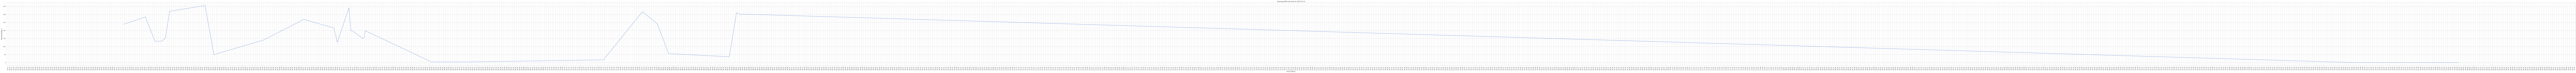

Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which e

Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1357 ticks ([18641.100694444445, ..., 18642.04236111111]), which e

Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which e

Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1370 ticks ([18641.09236111111, ..., 18642.043055555554]), which e

trip 27
trip e59042cb-80f1-472b-80b3-ab69441511ac
trip 2021-01-18
trip eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJXOEJqLU9Yd2VUNm5jNGNmRmxTYkJKM0hCdTdESGlfeXo5WjdaZGc0c1g0In0.eyJleHAiOjE2MTMzMzQ0NjksImlhdCI6MTYxMzMzNDE2OSwianRpIjoiM2ZkODcxYzMtNDUwMy00N2ZiLTk0NGItMjk2YjBkNWQzNjhmIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5nb21ldHJvYXBwLmNvbS9hdXRoL3JlYWxtcy9wbGF0Zm9ybSIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiJiNDc0MjE4ZS0zNTM1LTQ1MTQtYjBiNy02YTI3ODIzNmFjMjMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJnb21ldHJvLXVtYS1zZXJ2aWNlIiwic2Vzc2lvbl9zdGF0ZSI6Ijg3MDJiNTQ5LTZlMjItNDljMS1iNDMzLTgwZDM5NjZkNzYyYiIsImFjciI6IjEiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJzeXN0ZW1fYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoicHJvZmlsZSBlbWFpbCIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZ29tZXRyby1zeXN0ZW0tYWRtaW4ifQ.BgPWB5XiujCbm2FYfCVPKeXvprQU_mhkkt8ehsqM3nong-

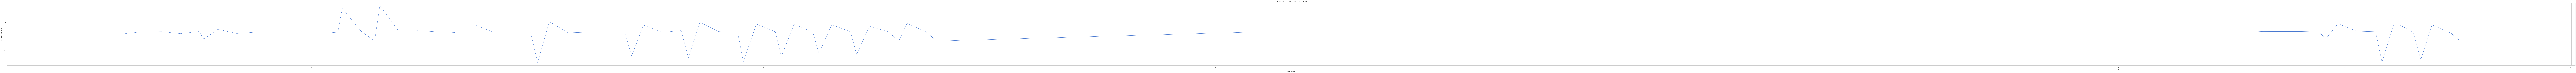

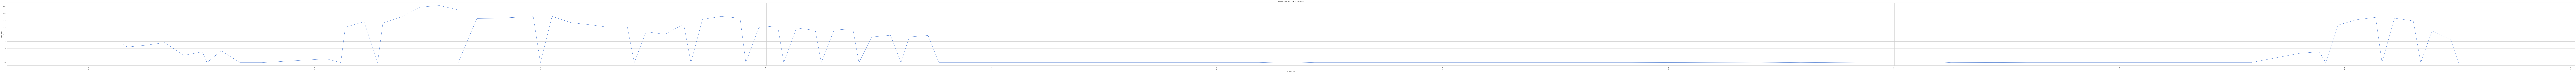

trip 63
trip a1e660a5-4b0f-4e4d-a631-97ca8264dd5b
trip 2021-01-22
trip eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJXOEJqLU9Yd2VUNm5jNGNmRmxTYkJKM0hCdTdESGlfeXo5WjdaZGc0c1g0In0.eyJleHAiOjE2MTMzMzQ0NjksImlhdCI6MTYxMzMzNDE2OSwianRpIjoiM2ZkODcxYzMtNDUwMy00N2ZiLTk0NGItMjk2YjBkNWQzNjhmIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5nb21ldHJvYXBwLmNvbS9hdXRoL3JlYWxtcy9wbGF0Zm9ybSIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiJiNDc0MjE4ZS0zNTM1LTQ1MTQtYjBiNy02YTI3ODIzNmFjMjMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJnb21ldHJvLXVtYS1zZXJ2aWNlIiwic2Vzc2lvbl9zdGF0ZSI6Ijg3MDJiNTQ5LTZlMjItNDljMS1iNDMzLTgwZDM5NjZkNzYyYiIsImFjciI6IjEiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJzeXN0ZW1fYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoicHJvZmlsZSBlbWFpbCIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZ29tZXRyby1zeXN0ZW0tYWRtaW4ifQ.BgPWB5XiujCbm2FYfCVPKeXvprQU_mhkkt8ehsqM3nong-

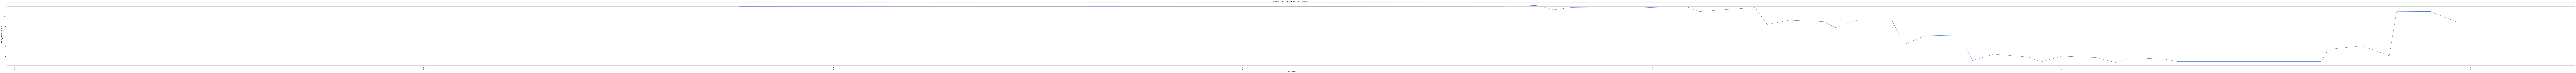

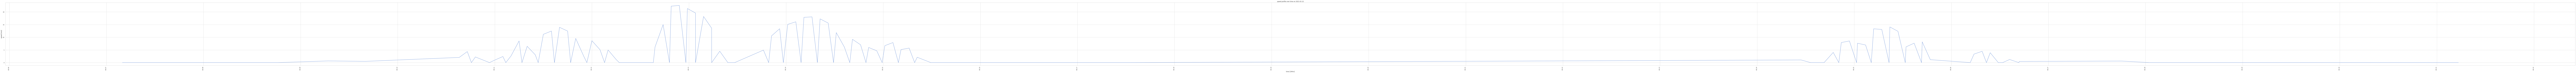

In [10]:
# define base directory for all figures
work_dir = os.path.join('..','..', 'resources', 'reports','figures','raw_data_viz')

# define variables to visualise
viz_cols = ['cumm_acceleration', 'bearing', 'acceleration', 'speed']

# get token to access api
token = get_api_token("../../../../Admin/authentication_files/uma_api_cred_2021-01-21.json")

# for each trip
for trip, participant, date in user_trips:
    
    print(f'trip {trip}')
    
    # convert date format
    old_date = date.split("/")
    new_date = old_date[2] + "-" + old_date[0].zfill(2) + "-"+ old_date[1]
    
    print(f'trip {participant}')
    print(f'trip {new_date}')
    print(f'trip {token}')
    
    # generate visuals from API data if token is valid
    try:
        df_api = get_raw_user_data(participant, new_date, token)
        df_raw = unpack_payload(df_api)
        df_raw_extra = prep_data_raw(df_raw)
        
        # if token not valid, get token then visualize
    except ValueError as token_error:
        print(token_error)
        print('refreshing authorisation...')
        token = get_api_token("../../../../Admin/authentication_files/uma_api_cred_2021-01-21.json")
        print(f'trip {token}')
        dataset = get_raw_user_data(participant, new_date, token)
        df_raw = unpack_payload(df_api)
        df_raw_extra = prep_data_raw(df_raw)

        for col in viz_cols:
            raw_trip_analysis_plot(df_raw_extra, col, participant, new_date, work_dir)
            
    # if date selected is out of range
    except json.decoder.JSONDecodeError as date_error:
        print(date_error)
        
        df_api = get_raw_user_data(participant, new_date, token)
        df_raw = unpack_payload(df_api)
        df_raw_extra = prep_data_raw(df_raw)
        
        # indicate correct value for trip and continue
        min_date = str(df_raw_extra.index.min().date())
        max_date = str(df_raw_extra.index.max().date())
        
        print('date passed in: ' + new_date)
        print(f'data date range: {min_date} to {max_date}')
        print('continue to next trip...')
        continue
        
    # if the api response is empty
    except AssertionError as no_data_error:
        print(no_data_error)
        print('continue to next trip...')
        continue
        



In [11]:
# # define authorisation parameters
# task = {"username": "gometro-system-admin",
#         "password": "3P6VP3ekMlPdi0IGM8VjJ6lEdZTNIuvR",
#         "client_id": "gometro-uma-service",
#         "grant_type": "password",
#        }

# # get authorisation credentials
# endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
# resp = requests.post(endpoint, data=task)


       
# if (resp.status_code < 200) and (resp.status_code >= 300):
#     raise ValueError('POST /tasks/ {}'.format(resp.status_code))

# # get access token
# token = resp.json()["access_token"]

# # get headers
# headers = {
#     'Authorization': f'Bearer {token}',
# }

# pid = '0563a400-c33a-477f-a656-2a3309d490cb'
# new_date = '2021-01-14'

# # get data
# endpoint = f'https://api.gometroapp.com/uma/v1/participants/{pid}/events/{new_date}'
# response = requests.get(endpoint, headers=headers)
# response.json()

In [12]:
# token = get_api_token("../../../../Admin/authentication_files/uma_api_cred_2021-01-21.json")

In [13]:
# df_api = get_raw_user_data('0ab124d9-edd9-410e-ab72-9fb8ffc7cedd', '2021-01-18', token)
# print(df_api.shape)
# df_api.head()

In [14]:
# df_raw = unpack_payload(df_api)
# print(df_raw.shape)
# df_raw.head()

In [15]:
# df_raw_extra = prep_data_raw(df_raw)
# print(df_raw_extra.shape)
# df_raw_extra.head()

In [16]:
# KeyError
# for col in viz_cols:
#     raw_trip_analysis_plot(df_raw_extra, col, participant, new_date, work_dir)

In [17]:
# min_date = str(df_raw_extra.index.min().date())
# print(min_date)
# max_date = str(df_raw_extra.index.max().date())
# print(max_date)

In [18]:
# str(df_raw_extra.index.min().date())

In [19]:
# str(df_raw_extra.index.max().date())

In [20]:
# df_raw_extra.index.min().date

In [21]:
# df_raw_extra.index.min().date